## 1. 计算jieba和thula的P，R，F值

基于文本‘express.txt’，标准文本是人工切分。

In [1]:
import jieba
import thulac

# 读取文本
with open('express.txt', 'r') as f:
    text = f.read()

# jieba分词
jieba_list = jieba.cut(text)
jieba_result = '/'.join(jieba_list)
print(f"jieba分词结果：\n{jieba_result}")

# thulac分词
thu = thulac.thulac(seg_only=True)
thulac_list = thu.cut(text)
thulac_result = '/'.join([word[0] for word in thulac_list])
print(f"thulac分词结果：\n{thulac_result}")

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 0.663 seconds.
Prefix dict has been built successfully.


jieba分词结果：
近些年来/，/快递/行业/发生/了/巨大/转变/，/各类/机器人/正试图/夺走/快递/小哥/的/工作/。/继/多家/公司/试验/无人机/送货/后/，/地面/送货/机器人/也/开始/上路/了/。/本月/月初/，/弗吉尼亚州/通过/法案/，/允许/地面/送货/机器人/上路/，/今天/爱达荷州/（/位于/美国/西北部/）/则/成/了/第二个/批准/送货/机器人/上路/的/州/，/不过/这项/法案/今年/7/月/1/日才/会/正式/生效/。
Model loaded succeed
thulac分词结果：
近些年/来/，/快/递/行业/发生/了/巨大/转变/，/各类/机器人/正/试图/夺/走/快递/小哥/的/工作/。/继/多/家/公司/试验/无人机/送货/后/，/地面/送货/机器人/也/开始/上路/了/。/本月月/初/，/弗吉尼亚州/通过/法案/，/允许/地面/送货/机器人/上路/，/今天/爱达荷州/（/位于/美国/西北部/）/则/成/了/第二/个/批准/送货/机器人/上路/的/州/，/不/过/这项/法案/今年/7月/1日/才/会/正式/生效/。


In [2]:
# 读取标准分词结果
with open('standard_express.txt', 'r', encoding='utf-8') as f:
    seg_result = f.read()

# 按空格切分标准分词结果
print(f"人工分词结果：\n{seg_result}")

人工分词结果：
﻿近些年来/，/快递/行业/发生/了/巨大/转变/，/各类/机器人/正/试图/夺走/快递小哥/的/工作/。/继/多家/公司/试验/无人机/送货/后/，/地面/送货/机器人/也/开始/上路/了/。/本月/月初/，/弗吉尼亚州/通过/法案/，/允许/地面/送货/机器人/上路/，/今天/爱达荷州/（/位于/美国/西北部/）/则/成了/第二个/批准/送货/机器人/上路/的/州/，/不过/这项/法案/今年/7月/1日/才会/正式/生效/。


In [3]:
# 得到分词结果的位置信息：例如(0,3)，表示从位置0到位置3为一个词
def get_split_pos(split_result):
    pos_list = []
    s = 0
    for word in split_result.split("/"):
        e = s + len(word)
        pos_list.append((s, e - 1))  # 记录开头和结尾
        s = e
    # print(pos_list)
    return set(pos_list)  # 需要转换为set来做与运算


def evaluate(ori, pred):
    pred_list = get_split_pos(pred)
    ori_list = get_split_pos(ori)
    pred_size = len(pred_list)
    ori_size = len(ori_list)
    right_size = len(pred_list & ori_list)  # 相与即可得到相同的元素
    # Recall
    recall_ = right_size / ori_size
    # Precision
    precision_ = right_size / pred_size
    # F-measure
    f1_score_ = 2 * precision_ * recall_ / (precision_ + recall_)
    print('P = {:.2%}'.format(precision_))
    print('R = {:.2%}'.format(recall_))
    print('F1-score = {:.2%}'.format(f1_score_))
    return recall_, precision_, f1_score_

In [4]:
# 计算jieba的P、R、F值
print('Jieba:')
_ = evaluate(seg_result[1:], jieba_result)


# 计算thulac的P、R、F值
print('Thulac:')
_ = evaluate(seg_result[1:], thulac_result)

Jieba:
P = 87.01%
R = 90.54%
F1-score = 88.74%
Thulac:
P = 75.90%
R = 85.14%
F1-score = 80.25%


## 2. 最大匹配分词算法

编程实现正向、后向搜索最大匹配分词算法，并计算其P、R、F值，方法同上（用dict_cn.txt词典做，切分express.txt）。

In [5]:
# 读取词典文件
with open('dict_cn.txt', 'r', encoding='GBK') as f:
    word_dict = [word.strip().split()[0] for word in f.readlines()]
print(word_dict[:5])

['的', '了', '是', '在', '和']


In [6]:
# 读取测试文本
with open('express.txt', 'r') as f:
    text = f.read().strip()

print(text)

近些年来，快递行业发生了巨大转变，各类机器人正试图夺走快递小哥的工作。继多家公司试验无人机送货后，地面送货机器人也开始上路了。本月月初，弗吉尼亚州通过法案，允许地面送货机器人上路，今天爱达荷州（位于美国西北部）则成了第二个批准送货机器人上路的州，不过这项法案今年7月1日才会正式生效。


In [7]:
# 正向最大匹配分词算法
def forward_max_match(text, max_len=5):
    words = []
    while text:
        for i in range(max_len, 0, -1):
            if text[:i] in word_dict:
                words.append(text[:i])
                text = text[i:]
                break
        else:
            words.append(text[0])
            text = text[1:]
    return words

In [8]:
# 反向最大匹配分词算法
def backward_max_match(text, max_len=5):
    words = []
    while text:
        for i in range(max_len, 0, -1):
            if text[-i:] in word_dict:
                words.insert(0, text[-i:])
                text = text[:-i]
                break
        else:
            words.insert(0, text[-1])
            text = text[:-1]
    return words

In [9]:
# 正向最大匹配分词结果
forward_result = forward_max_match(text)
print('正向最大匹配分词结果：')
print(forward_result)

# 反向最大匹配分词结果
backward_result = backward_max_match(text)
print('反向最大匹配分词结果：')
print(backward_result)

正向最大匹配分词结果：
['近些年', '来', '，', '快递', '行业', '发生', '了', '巨大', '转变', '，', '各类', '机器人', '正', '试图', '夺走', '快递', '小哥', '的', '工作', '。', '继', '多家', '公司', '试验', '无人机', '送货', '后', '，', '地面', '送货', '机器人', '也', '开始', '上路', '了', '。', '本月', '月初', '，', '弗吉尼亚州', '通过', '法案', '，', '允许', '地面', '送货', '机器人', '上路', '，', '今天', '爱达荷州', '（', '位于', '美国', '西北部', '）', '则', '成', '了', '第二个', '批准', '送货', '机器人', '上路', '的', '州', '，', '不过', '这项', '法案', '今年', '7', '月', '1', '日', '才', '会', '正式', '生效', '。']
反向最大匹配分词结果：
['近些年', '来', '，', '快递', '行业', '发生', '了', '巨大', '转变', '，', '各类', '机器人', '正', '试图', '夺走', '快递', '小哥', '的', '工作', '。', '继', '多家', '公司', '试验', '无人机', '送货', '后', '，', '地面', '送货', '机器人', '也', '开始', '上路', '了', '。', '本月', '月初', '，', '弗吉尼亚州', '通过', '法案', '，', '允许', '地面', '送货', '机器人', '上路', '，', '今天', '爱达荷州', '（', '位于', '美国', '西北部', '）', '则', '成', '了', '第二个', '批准', '送货', '机器人', '上路', '的', '州', '，', '不过', '这项', '法案', '今年', '7', '月', '1', '日', '才', '会', '正式', '生效', '。']


In [10]:
forward_words_result = '/'.join(forward_result)
print('正向最大匹配结果评价:')
_ = evaluate(seg_result[1:], forward_words_result)

backward_words_result = '/'.join(backward_result)
print('反向最大匹配结果评价:')
_ = evaluate(seg_result[1:], backward_words_result)

正向最大匹配结果评价:
P = 85.00%
R = 91.89%
F1-score = 88.31%
反向最大匹配结果评价:
P = 85.00%
R = 91.89%
F1-score = 88.31%


## 3. 词频统计

输出一段文本中所有的词，互相不重复。并计算词数（以express.txt 为例处理）。

{'近些年来': 1, '快递': 2, '行业': 1, '发生': 1, '了': 3, '巨大': 1, '转变': 1, '各类': 1, '机器人': 4, '正试图': 1, '夺走': 1, '小哥': 1, '的': 2, '工作': 1, '继': 1, '多家': 1, '公司': 1, '试验': 1, '无人机': 1, '送货': 4, '后': 1, '地面': 2, '也': 1, '开始': 1, '上路': 3, '本月': 1, '月初': 1, '弗吉尼亚州': 1, '通过': 1, '法案': 2, '允许': 1, '今天': 1, '爱达荷州': 1, '位于': 1, '美国': 1, '西北部': 1, '则': 1, '成': 1, '第二个': 1, '批准': 1, '州': 1, '不过': 1, '这项': 1, '今年': 1, '月': 1, '日才': 1, '会': 1, '正式': 1, '生效': 1}


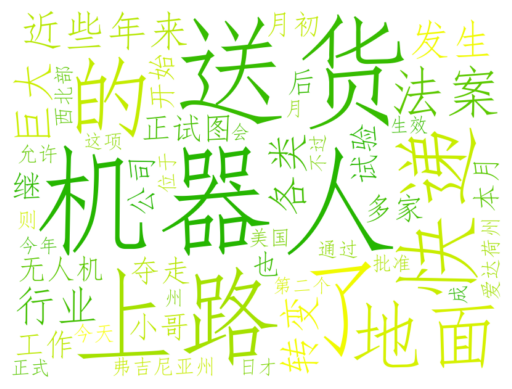

In [11]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import jieba

# 设置中文字体
font = 'C:\Windows\Fonts\simfang.ttf'

# 读入文本
with open('express.txt', 'r') as f:
    text = f.read()

# 去除停用词
stopwords = {'，', '。', '（', '）','1', '7'}
jieba_list = jieba.cut(text)
words = [word for word in jieba_list if word not in stopwords]

# 统计词频
counter = Counter(words)
word_freq = {word: freq for word, freq in counter.items()}
print(word_freq)
# 生成词云图
cmap = LinearSegmentedColormap.from_list('yellow_green', [(1, 1, 0), (0.1, 0.7, 0)])  # 设置黄绿建渐变色
wc = WordCloud(background_color='white', width=800, height=600, colormap=cmap, font_path=font, max_font_size=200)
wc.generate_from_frequencies(word_freq)

# 显示词云图
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
# from wordcloud import STOPWORDS

# 英文比较容易获得
# 中文需要去网上下载
# print(STOPWORDS)

## 4. 主角分布图

制作《理智与情感》中四个主角：Elinor，Marianne，Edward 和Willoughby 的分布图。


In [13]:
main_characters = ['Elinor', 'Marianne', 'Edward', 'Willoughby']

In [14]:
import nltk.corpus
from nltk.text import Text

sense_and_sensibility = Text(nltk.corpus.gutenberg.words('austen-sense.txt'))

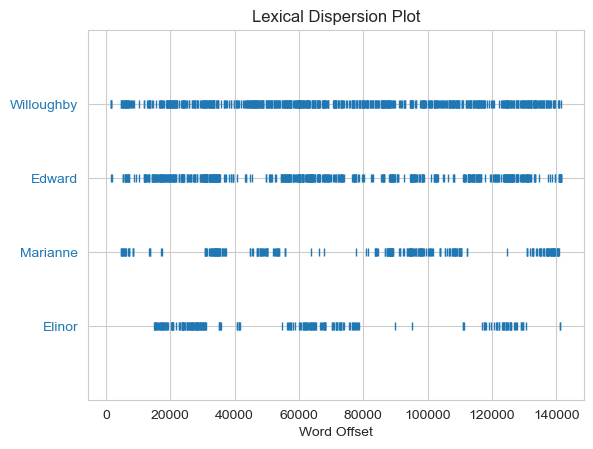

In [15]:
sense_and_sensibility.dispersion_plot(main_characters)

## 5. 词长—频率散点图

写一个函数，文本是其唯一输入参数，画出该文本的词长—频率散点图（以express.txt 为例处理）。

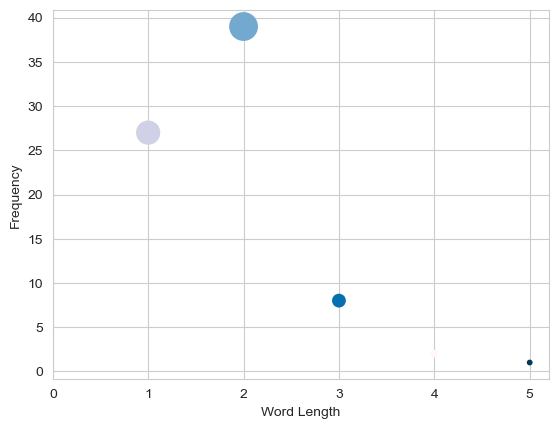

In [16]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def plot_word_freq(text):
    # 将文本拆分成单词
    words = text.split('/')
    # 统计每个单词的长度
    word_lengths = [len(word) for word in words]
    # 统计每个长度出现的频率
    freq_dict = Counter(word_lengths)
    # 将字典转换成两个列表，用于绘图
    x = list(freq_dict.keys())
    y = list(freq_dict.values())
    # 计算圆的大小，大小与数量成正比
    sizes = [count * 10 for count in y]
    # 绘制散点图，点的颜色为粉蓝渐变色，大小与数量成正比
    plt.scatter(x, y, s=sizes, c=np.arange(len(x)), cmap='PuBu')
    plt.xlabel("Word Length")
    plt.ylabel("Frequency")
    # 设置横坐标的显示规定为1,2,3,4,5
    plt.xticks(range(6))
    plt.show()


plot_word_freq(jieba_result)


## 6. 结尾词统计

使用正则表达式编程计算Moby Dick（NLTK.Book导入的text1）文本中，26个字母结尾词的各自次数。


In [17]:
import re
from nltk.book import text1

# moby_dick = Text(nltk.corpus.gutenberg.words('melville-moby_dick.txt'))

moby_dick = text1

# 创建一个字典来存储每个字母结尾词的次数
words_dict = {}
for letter in 'abcdefghijklmnopqrstuvwxyz':
    words_dict[letter] = 0

# 使用正则表达式来匹配每个字母结尾的单词
for word in moby_dick:
    m = re.search('[a-z]$', word.lower())
    if m:
        last_letter = m.group()
        words_dict[last_letter] += 1

# 打印每个字母结尾词的次数
for letter, count in words_dict.items():
    print(letter + ':', count, end=' ')


*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908
a: 5608 b: 930 c: 426 d: 23430 e: 42669 f: 8128 g: 8730 h: 6512 i: 2227 j: 4 k: 2654 l: 6535 m: 4190 n: 17437 o: 8755 p: 1981 q: 1 r: 11608 s: 27061 t: 23187 u: 1197 v: 20 w: 2682 x: 102 y: 12293 z: 11 

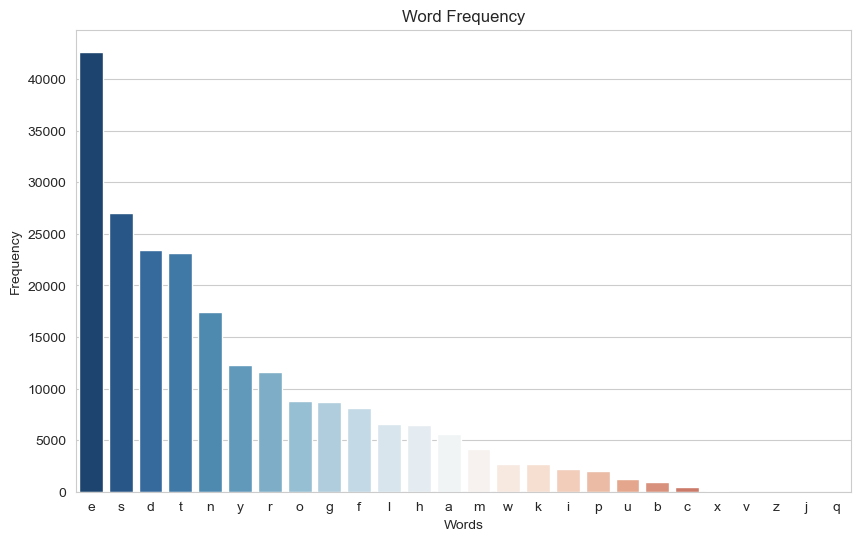

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# 将字典按照词频从高到低排序
sorted_freq = sorted(words_dict.items(), key=lambda x: x[1], reverse=True)

# 取出词频和词汇
freq = [x[1] for x in sorted_freq]
words = [x[0] for x in sorted_freq]

# 设置颜色渐变色板
color_palette = sns.color_palette("RdBu_r", len(words))

# 绘制柱状图
plt.figure(figsize=(10, 6))
sns.barplot(x=words, y=freq, palette=color_palette)

# 设置图形属性
plt.title('Word Frequency')
plt.xlabel('Words')
plt.ylabel('Frequency')

# 显示图形
plt.show()


## 7. 提取出书名，作者名字，语言

文件28885.txt是一篇小说，请用re提取出书名，作者名字，语言，以及小说正文

In [2]:
import re

# 打开文本文件
with open('28885.txt', 'r') as f:
    text = f.read()

# 提取书名
title_pattern = r'Title: (.*)'
title_match = re.search(title_pattern, text)
if title_match:
    title = title_match.group(1)
    print(f"Title: {title}")

# 匹配作者名字
author_pattern = r'Author: (.*)'
author_match = re.search(author_pattern, text)
if author_match:
    author_name = author_match.group(1)
    print(f"Author: {author_name}")

# 匹配语言
language_pattern = r'Language: (.*)'
language_match = re.search(language_pattern, text)
if language_match:
    language = language_match.group(1)
    print(f"Language: {language}")

# 匹配小说正文
novel_pattern = r'(?<=\*\*\* START OF THIS PROJECT GUTENBERG EBOOK).*?(?=\*\*\* END OF THIS PROJECT GUTENBERG EBOOK)'
novel_match = re.search(novel_pattern, text, re.DOTALL)
if novel_match:
    novel_text = novel_match.group(0)
    print(f"Main Text: \n{novel_text[:500]}")


Title: Alice's Adventures in Wonderland
Author: Lewis Carroll
Language: English
Main Text: 
 ALICE'S ADVENTURES IN WONDERLAND ***




Produced by Jana Srna, Emmy and the Online Distributed
Proofreading Team at http://www.pgdp.net (This file was
produced from images generously made available by the
University of Florida Digital Collections.)











ALICE'S ADVENTURES IN WONDERLAND

[Illustration: "Alice"]

[Illustration:

          ALICE'S.ADVENTURES
          IN.WONDERLAND
          BY.LEWIS.CARROLL
          ILLUSTRATED.BY
          ARTHUR.RACKHAM

          WITH A PROEM BY AUSTIN
